<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset

The following models will be evaluated:

| Model | Backbone | Image Size | Parameters| GFLOPs | Weight Size
| --- | --- | --- | --- | --- | ---
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 | 13.4MB
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 | 136MB
| RetinaNet | ResNet-50 | 800x800 | 34.5M | 303.5 | 130MB
| Faster R-CNN |  MobileNetV3-Large | 800x800 | 19.4M | 9.1 | 74.3MB
| Faster R-CNN |  MobileNetV3-Large  | 320x320 | 19.4M | 1.4 | 74.2MB 
| Faster R-CNN |  ResNet-50 | 800x800 | 41.8M | 269.1 | 160MB
| Mask R-CNN |  ResNet-50 | 800x800 | 44.4M | 269.1 | 170MB
| YOLOv5n |  Custom | 640x640 | 1.9M | 4.5 | 3.8MB
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 | 14MB
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 | 40.5MB
| YOLOv5l |  Custom |640x640 | 47M | 115.5 | 89.2MB
| YOLOv4 |  CSPDarknet53 | 608x608 | 64.4M | 128.9 | 258MB
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 | 17MB
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 | 119MB
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 | 121MB

<br>

**Note: GPU Runtime needed (hosted or local)**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=1, workers=2*




In [1]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Initialization

In [2]:
# Parameters

img_size = 640  # Image resolution (only for YOLO v3 and v5 models)
num_workers = 2  #  Data loader workers
batch_size = 1  # Data loader batch size

th = 0.5  # Threshold for confidence score of predicted bboxes to show

# Directories

import os
root_dir = os.getcwd()  # Root dir of project
dataset_dir = os.path.join(root_dir,'dataset_COCO17')

### Get requirements
*Note: Restart runtime after installation*

In [3]:
# Clone asset files
!cd {root_dir}
!git clone https://github.com/joangog/object-detection-assets
!mv -n {os.path.join(root_dir,'object-detection-assets','scripts')} ./
!mv -n {os.path.join(root_dir,'object-detection-assets','requirements.txt')} ./
!rm -rf {os.path.join(root_dir,'object-detection-assets')}


Cloning into 'object-detection-assets'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 195 (delta 82), reused 152 (delta 42), pack-reused 0
Receiving objects: 100% (195/195), 38.01 KiB | 1.09 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
# Install packages
!cd {root_dir}
!pip install -r requirements.txt

  Cloning https://github.com/googlecolab/colabtools.git to /tmp/pip-req-build-s0njctmy
  Running command git clone -q https://github.com/googlecolab/colabtools.git /tmp/pip-req-build-s0njctmy
     |████████████████████████████████| 26.5 MB 1.6 MB/s 
     |████████████████████████████████| 7.1 MB 19.1 MB/s 
     |████████████████████████████████| 5.6 MB 47.7 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
     |████████████████████████████████| 22.1 MB 62.0 MB/s 
     |████████████████████████████████| 101 kB 11.1 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=264045 sha256=024959db11aab8792f7fa02ca0e4475c7eec941736e114d78346d2f0d9d02dad
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=9337ca521a90889abe6fe090e7133caf7f4313c5

In [5]:
# Install YOLOv5
!cd {root_dir}
!git clone https://github.com/joangog/yolov5
!pip install -r {os.path.join(root_dir,'yolov5','requirements.txt')}

Cloning into 'yolov5'...
remote: Enumerating objects: 10387, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10387 (delta 0), reused 2 (delta 0), pack-reused 10381
Receiving objects: 100% (10387/10387), 10.73 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (7179/7179), done.
     |████████████████████████████████| 596 kB 4.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
# Install YOLOv4
!cd {root_dir}
!git clone https://github.com/joangog/yolov4
# !pip install -r {os.path.join(root_dir,'yolov4','requirements.txt')}


Cloning into 'yolov4'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 1050 (delta 33), reused 44 (delta 17), pack-reused 981
Receiving objects: 100% (1050/1050), 2.40 MiB | 9.86 MiB/s, done.
Resolving deltas: 100% (638/638), done.


In [7]:
# Install YOLOv3
!cd {root_dir}
!git clone https://github.com/ultralytics/yolov3
!pip install -r {os.path.join(root_dir,'yolov3','requirements.txt')}

Cloning into 'yolov3'...
remote: Enumerating objects: 9960, done.
remote: Total 9960 (delta 0), reused 0 (delta 0), pack-reused 9960
Receiving objects: 100% (9960/9960), 9.31 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (6718/6718), done.
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 180 kB 32.5 MB/s 
     |████████████████████████████████| 142 kB 56.1 MB/s 
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=f1072cdd137ba6da964e654f2bcd366b94fe5f4696d3f3b03c80b674234252bb
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d8f1de9a377cb24d2c9dda2b657ed29ea8e191096ea1bf64b52a0e8f2c791acc
  Stored in directory: /root/.cache/pip/wheels/3e/

In [8]:
# Fix dependencies
!cd {root_dir}
!pip install -r requirements.txt

  Cloning https://github.com/googlecolab/colabtools.git to /tmp/pip-req-build-xhnwpxr8
  Running command git clone -q https://github.com/googlecolab/colabtools.git /tmp/pip-req-build-xhnwpxr8


### Import packages

In [9]:
from google.colab import files
from google.colab import drive

import gdown

import os, sys
import math
import time
import copy
import re

import numpy as np
import pandas as pd
import json
import PIL
import cv2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

sys.path.append('yolov4')
from yolov4.tool.darknet2pytorch import Darknet as yolov4_Darknet
from yolov4.tool.utils import post_processing as yolov4_post_processing

### (Optional) Connect to GDrive for storage access
*Note: Not possible with local runtime*

In [10]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Download COCO 2017 validation dataset

In [11]:
!cd {root_dir}
!mkdir -p dataset_COCO17

In [12]:
# Download images
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -q -n val2017.zip -d {dataset_dir}

!cd {dataset_dir}

# Download annotations
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q -n annotations_trainval2017.zip -d {dataset_dir}
!cp {os.path.join(dataset_dir,'annotations','instances_val2017.json')} {os.path.join(dataset_dir,'val2017')}

--2022-01-17 16:57:19--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.41.108
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.41.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.6MB/s    in 49s     

2022-01-17 16:58:09 (15.8 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2022-01-17 16:58:16--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.48.124
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.48.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  17.2MB/s    in 16s     

2022-0

### Load COCO 2017 validation dataset

In [13]:
img_dir = os.path.join(dataset_dir,'val2017')
ann_file = 'instances_val2017.json'  # annotations
ann_path = os.path.join(img_dir,ann_file)

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_path, transforms = transforms)

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


### (Optional) Get dataset resolution information

In [14]:
img_ids = dataset.coco.getImgIds()
img_x_arr = []
img_y_arr = []

for img_id in img_ids:
  img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
  img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
  img_shape = img_tensor.shape
  img_x_arr.append(img_shape[1])
  img_y_arr.append(img_shape[2])

img_x_mean = np.mean(img_x_arr)
img_y_mean = np.mean(img_y_arr)

img_x_max = np.max(img_x_arr)
img_y_max = np.max(img_y_arr)

print(f'Mean resolution: {img_x_mean,img_y_mean}')
print(f'Maximum resolution: {img_x_max,img_y_max}')


Mean resolution: (483.543, 573.7548)
Maximum resolution: (640, 640)


### Load pre-trained model

In [15]:
!cd {root_dir}

# Empty cache to properly calculate max memory
torch.cuda.empty_cache() 

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5n' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'RetinaNet ResNet-50 FPN', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Faster R-CNN MobileNetV3-Large 320 FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5n', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv4', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'RetinaNet ResNet-50 FPN':
  model_id = 'retinanet_resnet50_fpn'
  model = M.retinanet_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Faster R-CNN MobileNetV3-Large 320 FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_320_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, progress=True)
  model_img_size = (3,320,320) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'YOLOv5n':
  model_id = 'yolov5n'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5n', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv4':
  model_id = 'yolov4'
  yolov4_cfg = os.path.join(root_dir,'yolov4/cfg/yolov4.cfg')
  yolov4_weights = os.path.join(root_dir,'yolov4.weights')
  model = yolov4_Darknet(yolov4_cfg)
  if not os.path.exists(yolov4_weights):
    !gdown --id '1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT' # Download weights
  model.load_weights(yolov4_weights)
  model_img_size = (3,model.height,model.width)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny', force_reload=True)
  model_img_size = (3,img_size,img_size)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp', force_reload=True)
  model_img_size = (3,img_size,img_size)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: torch>=1.7.0 not found and is required by YOLOv5, attempting auto-update...

requirements: torchvision>=0.8.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2022-1-17 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441MiB)




requirements: 3 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/3.77M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5n
	- Parameters: 1.9M
	- GFLOPs: 4.5


### (Optional) Test model with image sample
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


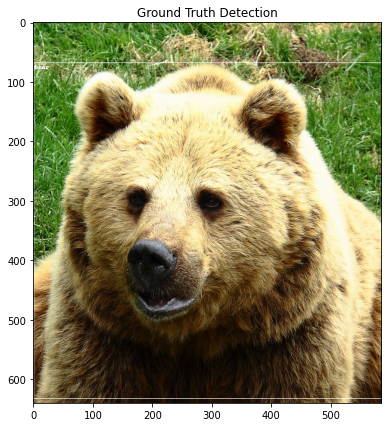

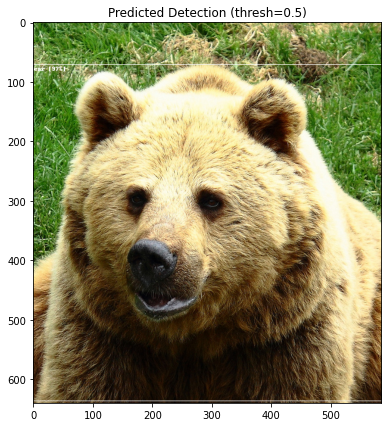

In [ ]:
%matplotlib inline

# Parameters
img_id = 285

# Get appropriate device for model
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
model.to(device)

# Get image sample
img_file = os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name'])
img = PIL.Image.open(img_file)
img_cv = cv2.imread(img_file)

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Format image
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor.float(),255).to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Get ground truth bboxes
true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLOv3' in model_name or 'YOLOv5' in model_name:
    pred = model([img])
  elif 'YOLOv4' in model_name:
    img_yolov4 = torch.from_numpy(cv2.cvtColor(cv2.resize(img_cv, (model.width, model.height)), cv2.COLOR_BGR2RGB).transpose(2, 0, 1)).float().div(255.0).unsqueeze(0).to(device)
    output = model(img_yolov4)
    pred = yolov4_post_processing(img, 0, 0.6, output)
  else:    
    pred = model([img_torchvision])

# Get predicted bboxes
pred_bboxes = []
pred_label_ids = []
pred_labels = []
# For YOLO v3 and v5 models
if 'YOLOv3' in model_name or 'YOLOv5' in model_name:
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)
# For YOLOv4 model
elif 'YOLOv4' in model_name:
  for bbox in pred[0]:
    if len(bbox) != 0:
      conf = bbox[4]
      if conf > th:  # Show only bboxes with high confidence score
        img_height = img_cv.shape[0]
        img_width = img_cv.shape[1]
        bbox_x1 = int(bbox[0] * img_width)
        bbox_y1 = int(bbox[1] * img_height)
        bbox_x2 = int(bbox[2] * img_width)
        bbox_y2 = int(bbox[3] * img_height)
        pred_bboxes.append(torch.as_tensor([bbox_x1,bbox_y1,bbox_x2,bbox_y2]))
        label_id = labels_inv[label_names[int(bbox[6])]]  # Convert YOLO label id to COCO label id
        pred_label_ids.append(label_id)  
        pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      label_id = pred[0]['labels'][i]
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f' [{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Evaluate model
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*

*Note 2: To get accurate maximum GPU memory usage logging, restart runtime when choosing a different model.*

In [16]:
# Clear cache for accurate maximum GPU memory usage logging
torch.cuda.empty_cache() 

# Get appropriate device for model
device = torch.device('cuda')
model.to(device)
print(f'Model: {model_name + ( " ("  + str(model_img_size[1]) + ") " if "yolo" in model_id else "")}')

# Evaluate model
evaluator, fps, max_mem, outputs = SE.evaluate(model, data_loader, device, img_size=model_img_size[1])

print(f'\nFPS: {fps}\n')

Model: YOLOv5n (640) 
Test:  [   0/5000]  eta: 0:21:41  model_time: 0.0828 (0.0828)  evaluator_time: 0.0199 (0.0199)  time: 0.2603  data: 0.1380  max mem: 49
Test:  [ 100/5000]  eta: 0:03:27  model_time: 0.0201 (0.0216)  evaluator_time: 0.0053 (0.0060)  time: 0.0422  data: 0.0023  max mem: 49
Test:  [ 200/5000]  eta: 0:03:16  model_time: 0.0197 (0.0209)  evaluator_time: 0.0042 (0.0059)  time: 0.0398  data: 0.0020  max mem: 49
Test:  [ 300/5000]  eta: 0:03:08  model_time: 0.0194 (0.0206)  evaluator_time: 0.0047 (0.0058)  time: 0.0395  data: 0.0019  max mem: 49
Test:  [ 400/5000]  eta: 0:03:03  model_time: 0.0204 (0.0207)  evaluator_time: 0.0045 (0.0058)  time: 0.0389  data: 0.0023  max mem: 49
Test:  [ 500/5000]  eta: 0:02:58  model_time: 0.0196 (0.0206)  evaluator_time: 0.0047 (0.0057)  time: 0.0394  data: 0.0021  max mem: 49
Test:  [ 600/5000]  eta: 0:02:54  model_time: 0.0201 (0.0206)  evaluator_time: 0.0050 (0.0059)  time: 0.0403  data: 0.0021  max mem: 49
Test:  [ 700/5000]  eta: 0

### Save metric results

In [20]:
cols = ['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_img_size_arr = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
max_mem_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_name for i in range(0,12)]
  model_img_size_arr += [model_img_size[1] for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  max_mem_arr += [max_mem for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

results = pd.DataFrame(np.column_stack([model, model_img_size_arr, model_params_arr, model_gflops_arr, fps_arr, max_mem_arr, iou_type, metric, iou, area, max_dets, score]))
results.columns = cols

In [21]:
# Save to file

results_dir = root_dir

gpu = torch.cuda.get_device_name(0).lower()
for pattern in [' ', 'tesla', 'geforce', 'nvidia']:  # Keep only short gpu name
  gpu = gpu.replace(pattern,'')

results_file = f'COCO17_{gpu}_{model_id + ("_" + str(model_img_size[1]) if "yolo" in model_id else "")}_metrics.csv'
results_path = os.path.join(results_dir, results_file)

if os.path.exists(results_path):
      os.remove(results_path)
results.to_csv(results_path)

### (Optional) Save results to GDrive

In [22]:
# Save to GDrive
gdrive_results_dir = '/content/drive/MyDrive/object-detection-results/COCO17'
!mkdir gdrive_results_dir
gdrive_results_path = os.path.join(gdrive_results_dir, results_file)
if os.path.exists(gdrive_results_path):
      os.remove(gdrive_results_path)
results.to_csv(gdrive_results_path)

mkdir: cannot create directory ‘gdrive_results_dir’: File exists
